In [7]:
# Module imports
import qexpy as q
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from bokeh.io import output_notebook
output_notebook(hide_banner=True)

## ENPH453 Session 5: Feb 5, 2019
### Alex White, Curtis Shewchuk, Viraj Bangari

## Photon absorption of Silicon

### Calibration Steps

##### Optical Setup
We set up our apparatus like this block diagram:

![img1](data/monochromator_calibration_1.png)

The goal is to maximize the throughput of the monochromator by adjusting the optics. We measured the intensity of the monochromator using the scope and the photodiode. We kept tweaking things until the lowest voltage reading was seen from the scope. This meant that we were getting as high of a throughput as possible.

We then turned of all the lights and the broadband in the room, and observed the dark current in the scope. We then optically blocked the photodiode using the long pass filter and turned on broadband. This allowed us to see how much spectral scattaring came from the broadband itself. We adjusted the optics reaching into the photodetector by adding an aperature to reduce the excess noise from the light source. With this, we kept adjusting our apparatus to reduce the stray scattering from the broadband.

Photograph of finalized optical setup going in and out of the monochromator:

![img2](data/optical_setup.jpg)

##### Monochromator Calibration
Next, our goal was to calibrate the monochromator. We replaced the broadband light source with the Na light source. From our lab manual, we know that a spectral line exists at 589.2nm. We connected the photodiode do the Oscilloscope and kept adjusting our monochromator until a maximum DC voltage was read. This was determinined by setting the scoped volts per div to $5mV / div$. This occured at a reading of $283 \pm 1 nm$. The spectral peak was observed between $279 \pm 1nm$ and $289 \pm 1nm$.


##### Lock-in amplifier reading
We added the optical chopper in front of the monochromator. We had it run at 200Hz, and connected the output of the photodiode and the reference frequency to the chopper. We used the "auto-phase" functionality of the lock-in amplifier to deal with delays between the photodiode and reference signal connections. This was done by manually setting the phase to 90 degrees and then pressing "auto-phase".

To get the DC signal from the amplitude-modulated signal, we need the average value at a frequency of 0Hz. Therefore, a low-pass filter (built-into the amplifier) will need to be used to get the proper reading. We used a LPF time constant of $\tau = 1 second$ with a $-20 dB / decade$. We need to wait a minimum of $5 \tau$ before recording a measurement. This means that a higher time constant results in a cleaner signal, but longer time needed to read a measurement. A block diagram and photograph of this setup is presented below.

![img3](data/lock_in_photodiode.png)

To get a better intuitive "feel" of the lock-in filter and our equipment, we switched to the broadband filter, pyrometer and altered the wavelength using the monochromator. We observed how long it took for the reading the reach steady state and verified the $5\tau$ rule-of-thumb was correct. We decided that a time constant of $\tau= seconds$ resulted in a reading that was stable while being possible

### Experimental Setup and Procedure

We modified our apparatus to have the silicon filter applied after the monochromator. The cutoff wavelength for Si is:

$\lambda_c = hc/E_g = 1130nm$

and the phonon energy is:

$E_p = ~0.1eV $ or $\lambda_p = 124nm$ around $\lambda_c$

We are interested in the range of $\lambda_c \pm \lambda_p$. Therefore, our desired spectral range will be from $1130nm \pm 200nm$ or $1330$ to $930nm$. We're also interested in the high energy range, so our desired spectral will require higher energy photons. Therefore, we are going to start at $830nm$ wavelengths instead.

Considering an offset of $283nm - 589.2nm = -306nm$ of the monochromator, the monochromator values will need to be from $524nm$ to $1024nm$.

In [8]:
monochromator_offset = q.Measurement(283, 1, units='nm')
calibration = monochromator_offset - 589.2 
print("Calibration offset", calibration)

lambda_c = 1130
lambda_p = 200
print("Spectral range {} nm  to {} nm"
      .format(lambda_c - lambda_p - 100, lambda_c + lambda_p))

print("Monochromator range {} nm to {} nm"
      .format(lambda_c - lambda_p + calibration - 100, lambda_c + lambda_p + calibration))

Calibration offset -306 +/- 1
Spectral range 830 nm  to 1330 nm
Monochromator range 524 +/- 1 nm to 1024 +/- 1 nm


The block diagram of our experiment is:

![pyrolol](data/pyrometer_measurement.png)

We used a time constant of $\tau = 1s$, a oscillation frequency of $144Hz$, and the auto-gain and auto-phase features on the lock-in amplifier.

Our procedure is to take a measurement without the silicon filter. We would repreat this process 

We would then go through the entire spectral range and keep track of all the measurements. We first do this process without the silicon filter, then with the filter, and finally with the filter and the longpass. 

We used a labVIEW program that automatically took a set of measurements between the spectral range mentioned earlier. The initial results showed the general spectral range for the broadband light source, but the plot was noisy. When we plugged the pyrometer singal into the oscilliscope, the modulations were not visible. We believe this if we optimize our optical setup for higher throughput so that the pyrometer signal is visible in the scope, we should get a cleaner curve.

#### Initial Measurements

<IPython.core.display.Javascript object>


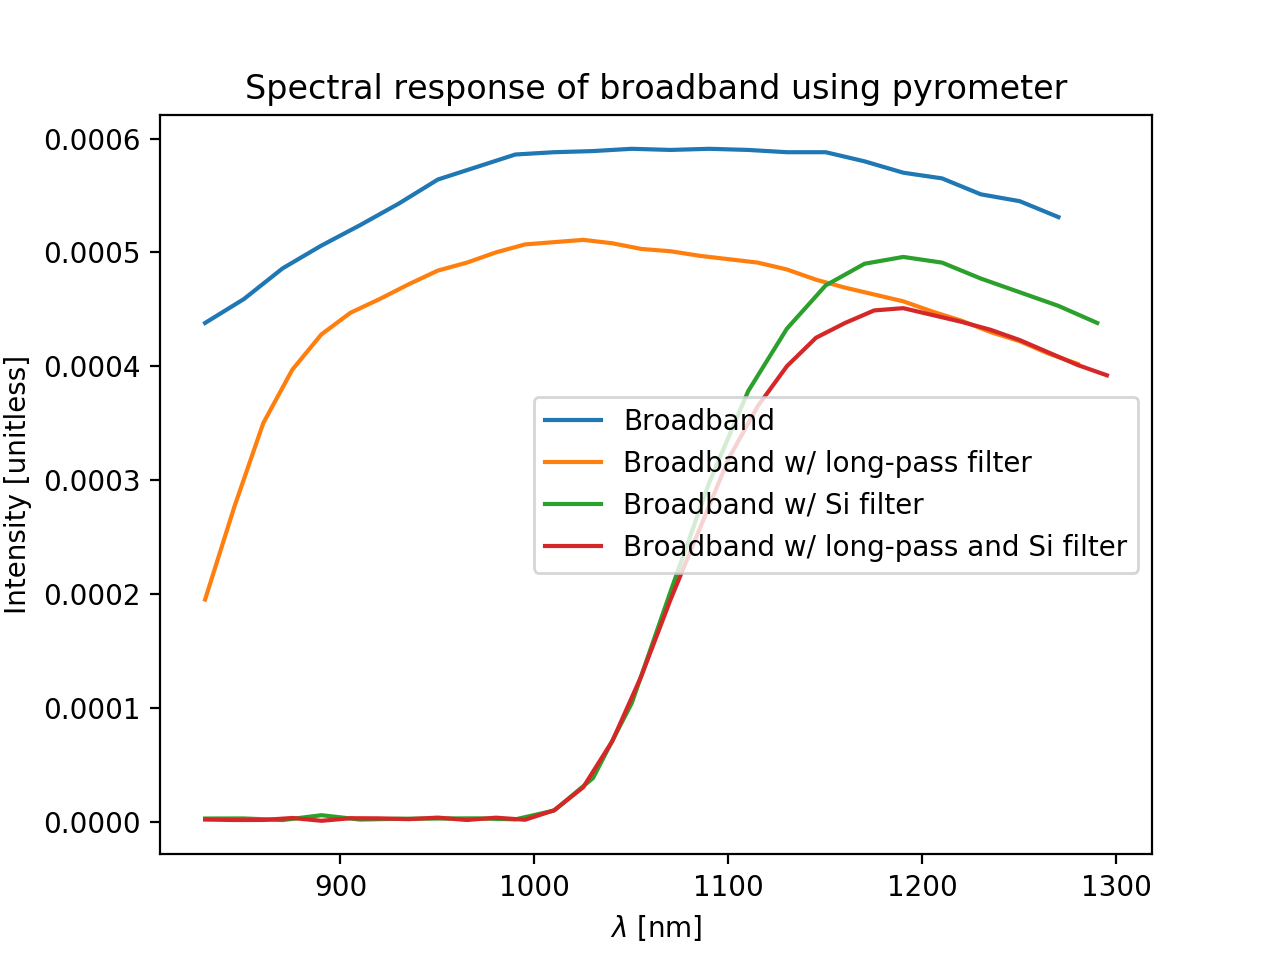

In [9]:
df_si = pd.read_csv(
    './data/spectral_silicon.csv',
    header=None,
    names=['lambda', 'intensity'])
df_py = pd.read_csv(
    './data/spectral_response_broad_pyro.csv',
    header=None,
    names=['lambda', 'intensity'])
df_long = pd.read_csv(
    './data/spectral_long_pass_more_points.csv',
    header=None, 
    names=['lambda', 'intensity'])
df_long_si = pd.read_csv(
    './data/spectral_silicon_long_pass_more_points.csv',
    header=None,
    names=['lambda', 'intensity'])

plt.figure()
plt.plot(
    df_py['lambda'] - calibration.mean,
    df_py['intensity'],
    label="Broadband")
plt.plot(
    df_long['lambda'] - calibration.mean,
    df_long['intensity'],
    label="Broadband w/ long-pass filter")
plt.plot(
    df_si['lambda'] - calibration.mean,
    df_si['intensity'],
    label="Broadband w/ Si filter")
plt.plot(
    df_long_si['lambda'] - calibration.mean,
    df_long_si['intensity'],
    label="Broadband w/ long-pass and Si filter")
plt.title("Spectral response of broadband using pyrometer")
plt.xlabel("$\lambda$ [nm]")
plt.ylabel("Intensity [unitless]")
plt.legend()

#### Analysis

We performed a simple curve fit on the ratio of the the broadband w/ LPF and broadband w/ LPF & Si filters. With simple fitting, we were able to achieve an average Si bandgap of 1.1 eV.

<IPython.core.display.Javascript object>


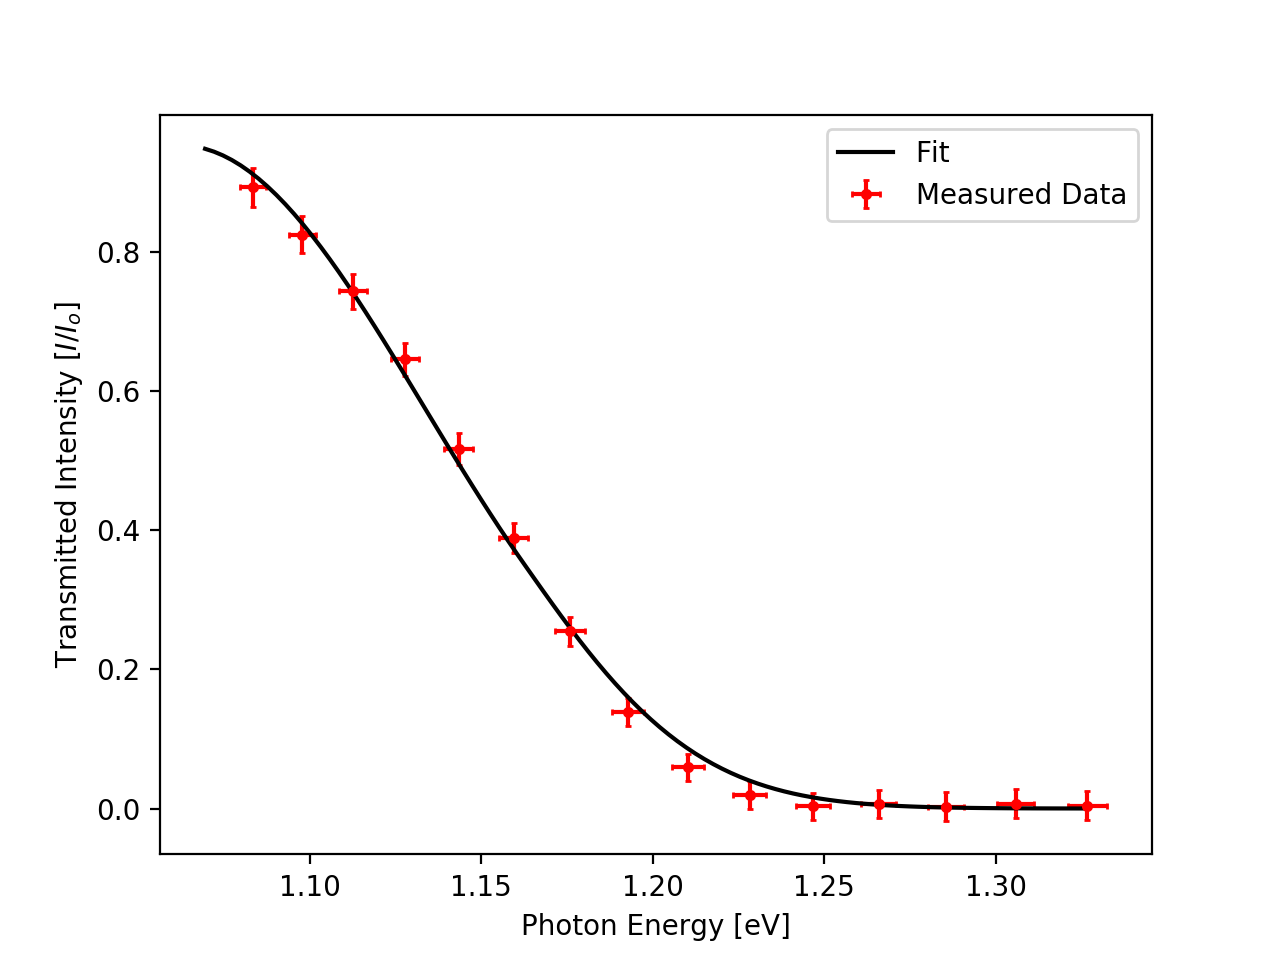

Fit parameters: (R, C, Eg)
[0.0237038  1.92255143 1.11231401]


In [170]:
h = 4.136e-15 # eV s
c = 3e17 # nm/s
R = 0.3 
x = 1/1000 # mm

def transmittance(Eph, R, C, Eg):
    Ep = 0.050
    kB = 8.617 # eV / K
    T = 300 # K
    x = 1/1000 # m
    # low alpha
    alpha_low = (Eph - Eg + Ep)**2 / (np.exp(Ep/(kB*T)) - 1)
    # High alpha
    alpha_high =(Eph - Eg + Ep)**2 / (np.exp(Ep/(kB*T)) - 1) + \
                (Eph - Eg - Ep)**2 / (1 - np.exp(-Ep/(kB*T)))
    alpha = np.where(Eph > Ep + Eg, alpha_high, alpha_low)
    return (1 - R) ** 2 * np.exp(-C * alpha * x)


Io = q.MeasurementArray(df_long['intensity'].values, 1e-5)
I = q.MeasurementArray(df_long_si['intensity'][:-1].values, 1e-5)
I_Io = I / Io
wavelengths = q.MeasurementArray(
    (df_long['lambda'] - calibration.mean).values, 4)
energy = h * c / wavelengths

# Curve fitting for phonon assisted absorption
tStart = 7
tEnd = 24
t_popt, t_pcov = \
    curve_fit(transmittance, 
              xdata=energy.means[tStart:tEnd],
              ydata=I_Io.means[tStart:tEnd],
              p0=np.array([0.1, 1, 1.1]))
# Plotting
plt.figure()
energyFit = np.linspace(energy.means[tStart], energy.means[tEnd-2], 100)
transmittance_fit = transmittance(energyFit, t_popt[0], t_popt[1], t_popt[2])
plt.errorbar(energy.means[tStart:tEnd-2], 
             I_Io.means[tStart:tEnd-2],
             xerr=energy.stds[tStart:tEnd-2],
             yerr=I_Io.stds[tStart:tEnd-2],
             fmt='.',
             capsize=1,
             color='red',
             label="Measured Data")
plt.plot(energyFit, 
         transmittance_fit,
         label="Fit",
         color='black')

plt.xlabel("Photon Energy [eV]")
plt.ylabel("Transmitted Intensity [$I/I_o$]")
plt.legend()

print("Fit parameters: (R, C, Eg)")
print(t_popt)

### Photovoltaic Effect Bandgap Measurement

#### Apparatus and Calibration 
The apparatus and calibration for this experiment is identical as above. The only difference is that we replaced the pyrometer with the photodiode. We also used the same spectral range of $930nm$ to $1330nm$.

We repeated the experiment for times:
1. No filter
2. Long pass filter
3. Silicon filter
4. Silicon and Longpass

We took 80 measurements, each 5nm apart starting at 624nm. 

#### Initial measurements

<IPython.core.display.Javascript object>


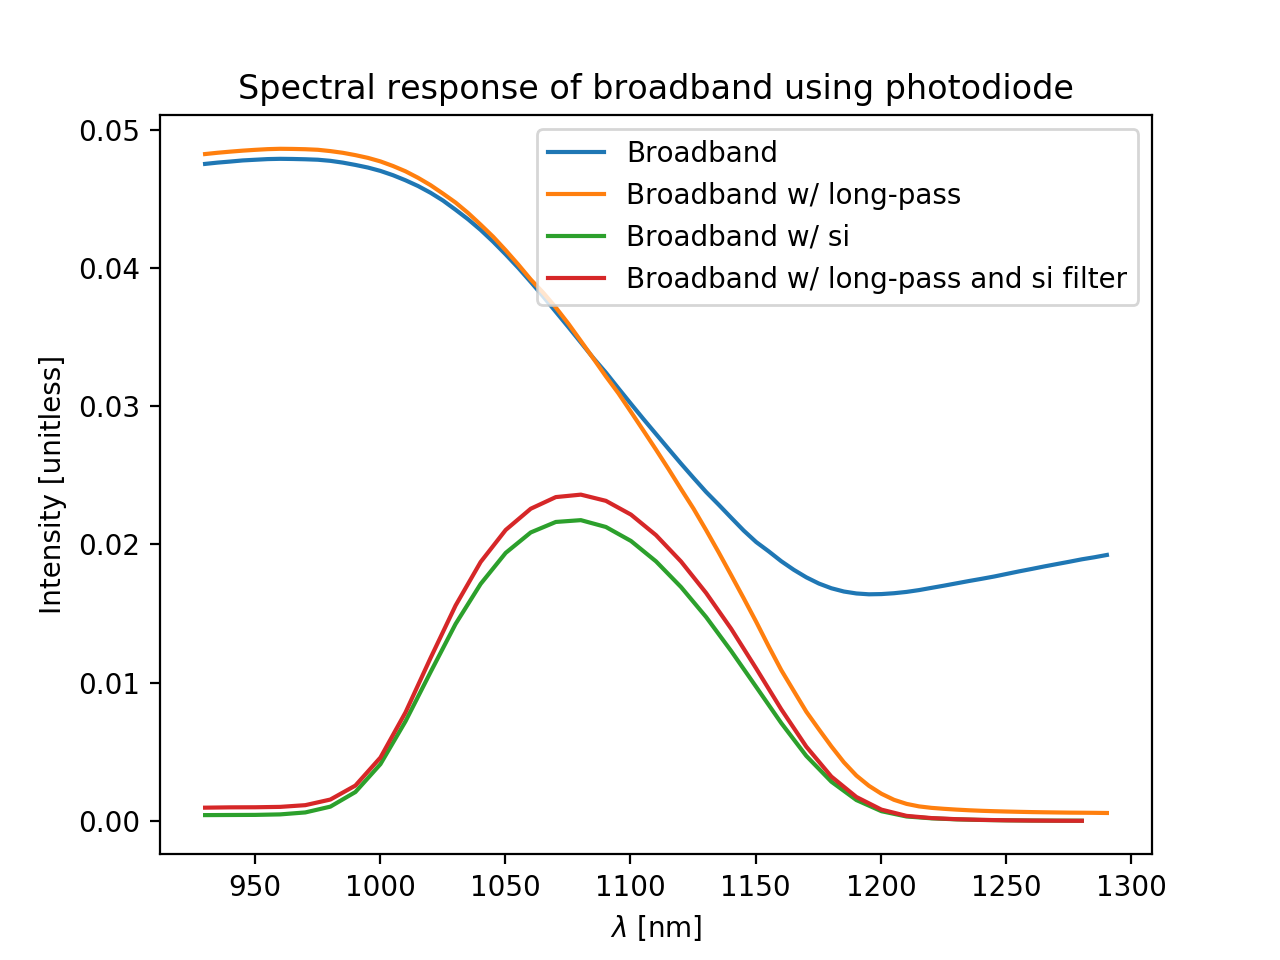

In [9]:
df_diode = pd.read_csv(
    './data/second_experiment_first_collection.csv',
    header=None,
    names=['lambda', 'intensity'])

df_diode_long = pd.read_csv(
    './data/second_experiment_long_pass_second_run.csv',
    header=None,
    names=['lambda', 'intensity'])

df_diode_si = pd.read_csv(
    './data/second_experiment_silicon.csv',
    header=None,
    names=['lambda', 'intensity'])

df_diode_long_si = pd.read_csv(
    './data/second_experiment_silicon_long_pass.csv',
    header=None,
    names=['lambda', 'intensity'])
    
    
plt.figure()
plt.plot(
    df_diode['lambda'] - calibration.mean,
    df_diode['intensity'],
    label="Broadband")
plt.plot(
    df_diode_long['lambda'] - calibration.mean,
    df_diode_long['intensity'],
    label="Broadband w/ long-pass")
plt.plot(
    df_diode_si['lambda'] - calibration.mean,
    df_diode_si['intensity'],
    label="Broadband w/ si")
plt.plot(
    df_diode_long_si['lambda'] - calibration.mean,
    df_diode_long_si['intensity'],
    label="Broadband w/ long-pass and si filter")

plt.title("Spectral response of broadband using photodiode")
plt.xlabel("$\lambda$ [nm]")
plt.ylabel("Intensity [unitless]")
plt.legend()

### Bandgap Measurement by Resistivity

#### Apparatus
Our apparatus came presetup. We have a computer running Windows XP which is connected to a Keithly 2010 temperature sensor. A thermocouple is connected to the Keithly, whose parallel connects are connected to a cold junction. The silicon sample itself is connected to a four point probe with a Keithly 2400-LV current source. We spent some time understanding out apparatus and how it works. We were able to turn on the oven and have the temperature updated on the thermocouple, albiet without the cold junction.

![heat_diagram](data/app3diagram.png)

#### Experiemental setup
We first put the thermocouple in an icebath with distilled water. We used the front panel temperature, a reading of $0.5$ celsius to calibrate the actual temperature of $0$ celsius. We used a current of 105 micro amps.

#### Initial Results
This was our hystersis plot:

<IPython.core.display.Javascript object>


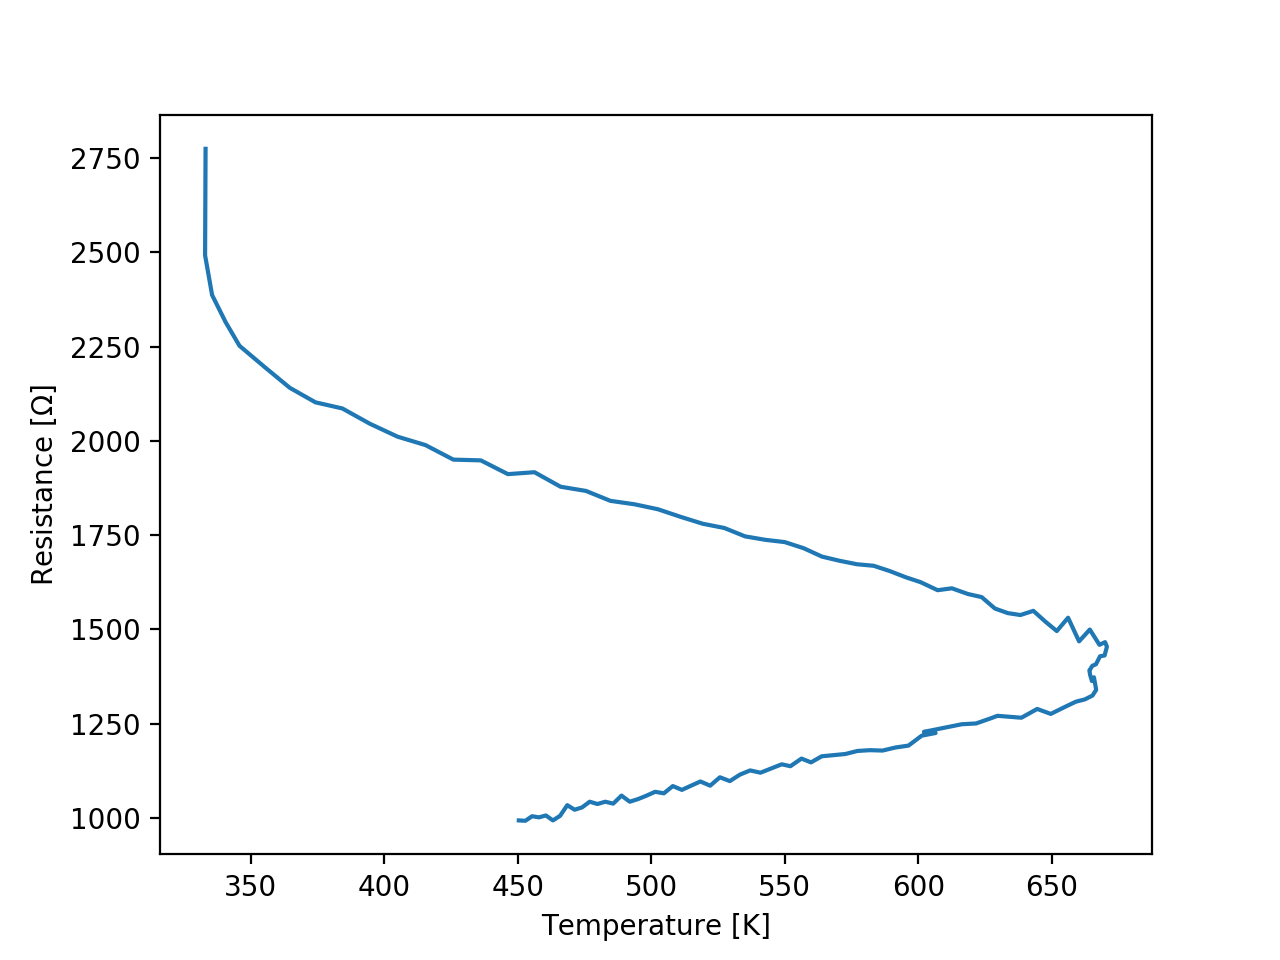

In [11]:
df_temp = pd.read_csv('./data/experiemnt3_0.csv', sep='\t')

plt.figure()
plt.plot(df_temp["Temperature"], df_temp["Resistance"])
plt.xlabel("Temperature [K]")
plt.ylabel("Resistance [$\Omega$]")

We repeated this experiment many times, since no curve fits seemed to fit our original curve. We noticed that our data was mostly exponential at first, but at high temperatures, we observed a massive jump in resistance. We atrribute this to melding solder, since we were beyond the melting point of 400 celsius. Therefore, our fit will only be done on the expoentnial part of the data.

The following graphs were the exponetial areas that were extracted from the data collection.

In [ ]:
def R(T, Eg, A):
    kb = 8.617e-5
    ue = 739343109.3882 * T**(-2.3096)
    uh = 177871187.4661 * T**(-2.25)
    Eg_T = Eg * 
    
    return A * np.exp(Eg/(2 * kb * T))/((ue + uh)* T**(3/2))


<IPython.core.display.Javascript object>


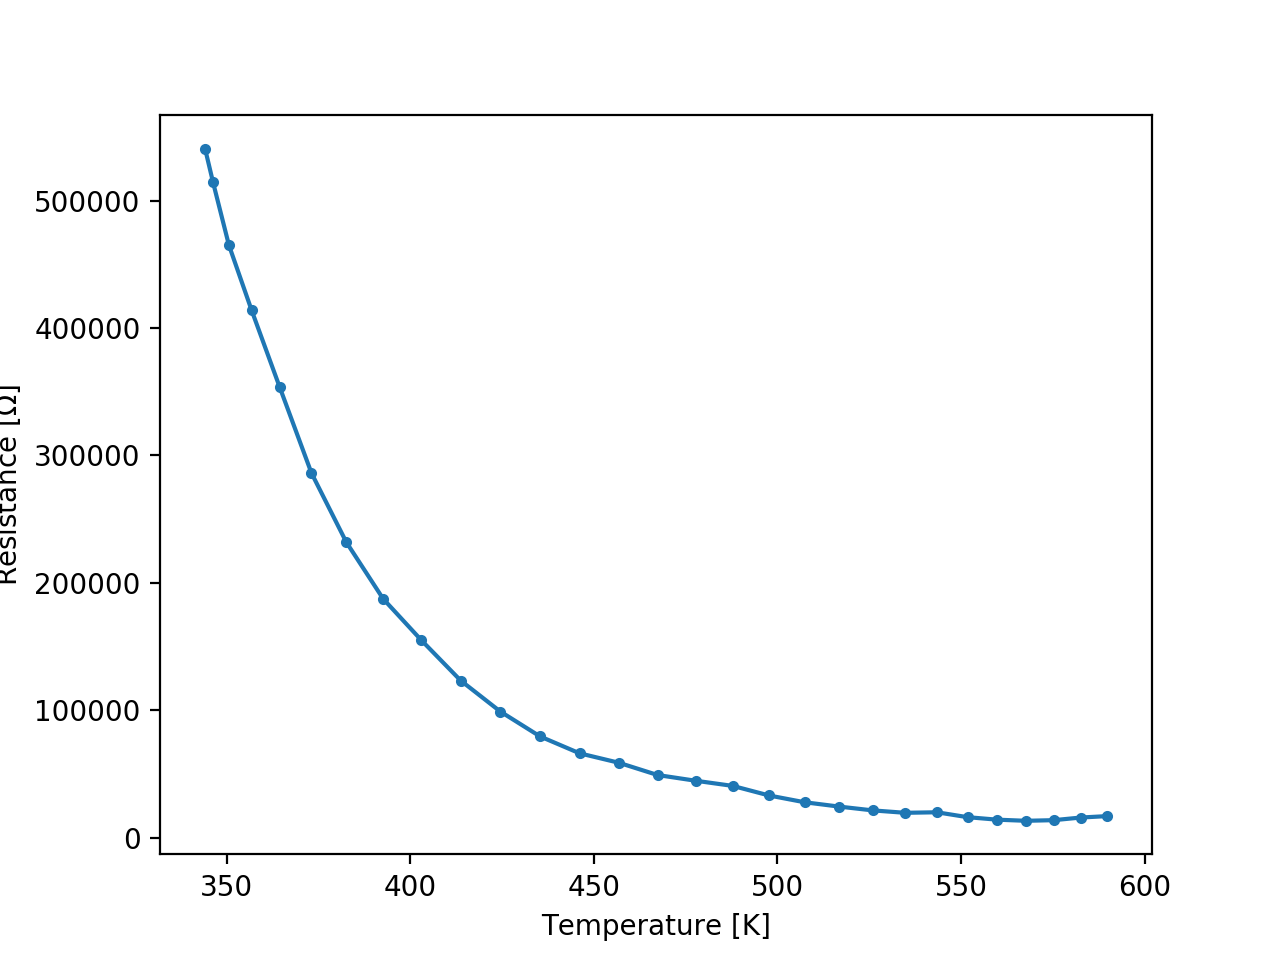

In [12]:
df_temp1 = pd.read_csv('./data/experiment3_1.csv', sep='\t')

startIndex = 0
endIndex = 29
temperature = df_temp1["Temperature"][startIndex:endIndex]
resistance = df_temp1["Resistance"][startIndex:endIndex]

plt.figure()
plt.plot(temperature, resistance, '.-')
plt.xlabel("Temperature [K]")
plt.ylabel("Resistance [$\Omega$]")

<IPython.core.display.Javascript object>


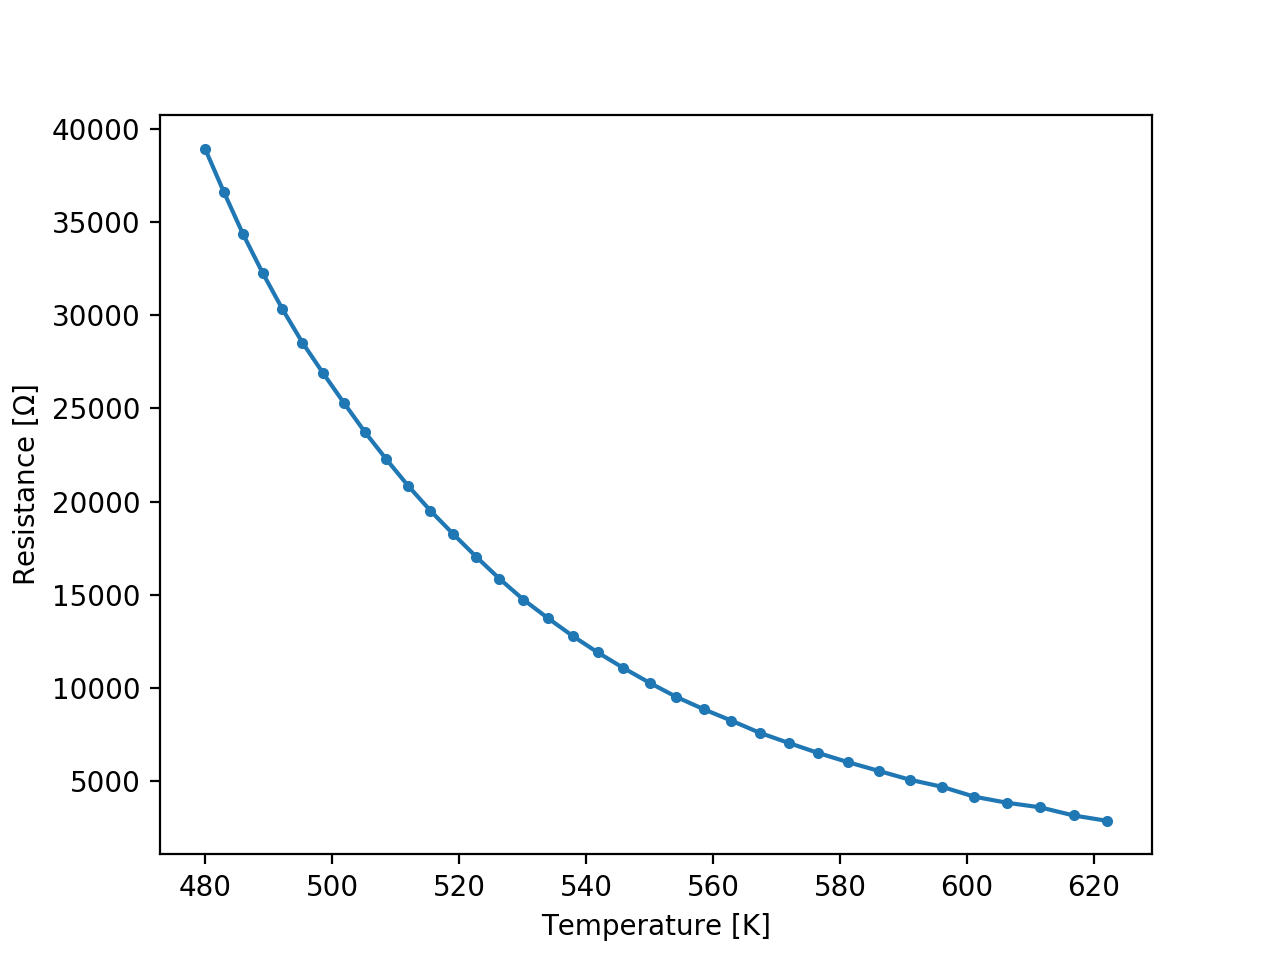

In [14]:
df_temp2 = pd.read_csv('./data/experiment3_2.csv', sep='\t')

startIndex = 47
endIndex = -1
temperature = df_temp2["Temperature"][startIndex:endIndex]
resistance = df_temp2["Resistance"][startIndex:endIndex]

plt.figure()
plt.plot(temperature, resistance, '.-')
plt.xlabel("Temperature [K]")
plt.ylabel("Resistance [$\Omega$]")

<IPython.core.display.Javascript object>


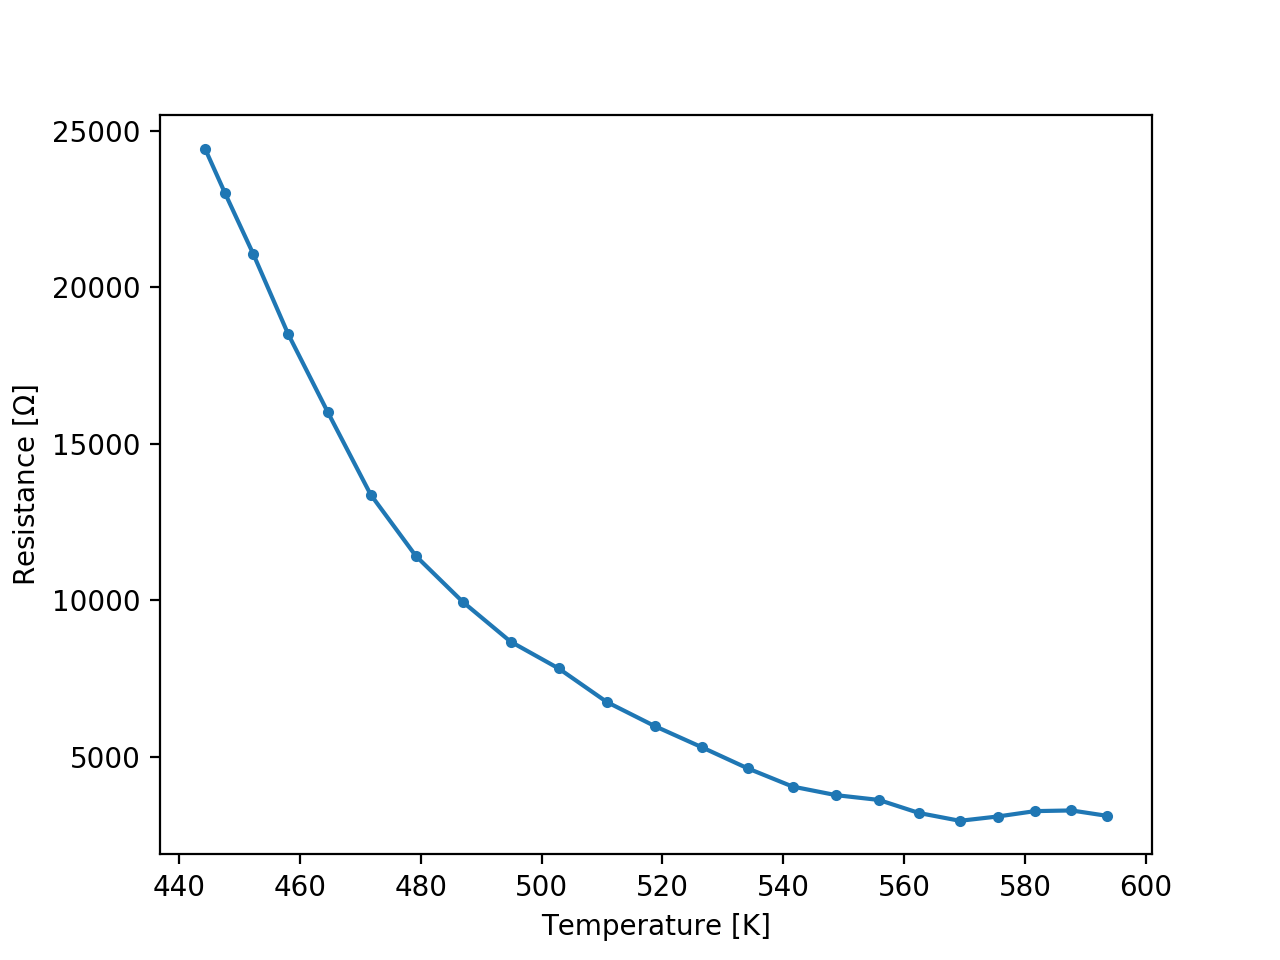

In [15]:
df_temp3 = pd.read_csv('./data/experiment3_3.csv', sep='\t')

startIndex = 0
endIndex = 23
temperature = df_temp3["Temperature"][startIndex:endIndex]
resistance = df_temp3["Resistance"][startIndex:endIndex]

plt.figure()
plt.plot(temperature, resistance, '.-')
plt.xlabel("Temperature [K]")
plt.ylabel("Resistance [$\Omega$]")